# Common Analysis

More and more frequently summers in the western US have been characterized by wildfires with smoke billowing across multiple western states. There are many proposed causes for this: climate change, US Forestry policy, growing awareness, just to name a few. Regardless of the cause, the impact of wildland fires is widespread. There is a growing body of work pointing to the negative impacts of smoke on health, tourism, property, and other aspects of society.

This Common Analysis sets the stage for the subsequent assignments. Part 1 is a base analysis on the wildfires in Cedar City, Utah. The wildfire data is from [USGS](https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81), available in ArcGIS and GeoJSON formats.

## Preliminaries and Modules

In [36]:
import os, json, time

# The module pyproj is a standard module that can be installed using pip or your other favorite
# installation tool. This module provides tools to convert between different geodesic coordinate systems
# and for calculating distances between points (coordinates) in a specific geodesic system.
from pyproj import Transformer, Geod

import geojson

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

The following block is the city information of Cedar City, Utah:

In [2]:
SAMPLE_DATA_FILENAME = "USGS_Wildland_Fire_Combined_Dataset.json"
CITY_LOCATIONS = {
    'cedar_city' :    {'city'   : 'Cedar City',
                       'latlon' : [37.6775, -113.0619]}
}

## Load Data

In [3]:
print(f"Attempting to open '{SAMPLE_DATA_FILENAME}'")
geojson_file = open(SAMPLE_DATA_FILENAME,"r")
print(f"Using GeoJSON module to load sample file '{SAMPLE_DATA_FILENAME}'")
gj_data = geojson.load(geojson_file)
geojson_file.close()

Attempting to open 'USGS_Wildland_Fire_Combined_Dataset.json'
Using GeoJSON module to load sample file 'USGS_Wildland_Fire_Combined_Dataset.json'


The dataset contains several keys, and the main information needed for this analysis is under `features`.

In [4]:
# Print the keys from the object
gj_keys = list(gj_data.keys())
print("The loaded JSON dictionary has the following keys:")
print(gj_keys)

The loaded JSON dictionary has the following keys:
['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features']


In [7]:
len(gj_data['features'])

135061

In this dataset, a total of 135,061 fires are recorded.

## Data Cleaning
Since we are only analyzing the last 60 years of sildland fires, we will eliminate all fires happened before 1963. Also, I'm only analyzing for Cedar City, Utah. Thus, the following filtering rules are applied:
- The estimate only considers the last 60 years of wildland fires (1963-2023).
- The estimate only considers fires that are within 1250 miles of your assigned city.

The following code block contains 2 functions. The first one converts the biggest ring from the fire geometry to `epsg4326` for calculating distance. The second function calculates the average distance from the city to fire perimeter.

In [8]:
# Transform feature geometry data

# The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
# The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()

    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring


# The function takes two parameters:
#  A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#  Ring_data - a list of decimal degree coordinates for the fire boundary

#  The function returns the average miles from boundary to the place
def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        distances_in_meters.append(d[2])
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    return average

To filter out the fires for analysis, the following for loop iterates through every fire, check the year of occurrence and distance between city and the fire, and save the fire incidents in the list `cedar_city_features`.

In [16]:
from tqdm import tqdm

place = CITY_LOCATIONS["cedar_city"]
gj_features = gj_data['features']
cedar_city_features = []
for feature in tqdm(gj_features):
    wf_year = feature['attributes']['Fire_Year']
    wf_name = feature['attributes']['Listed_Fire_Names'].split(',')[0]
    wf_size = feature['attributes']['GIS_Acres']
    wf_type = feature['attributes']['Assigned_Fire_Type']
    
    if 'rings' not in list(feature['geometry'].keys()):
        continue
    ring_data = feature['geometry']['rings'][0]
    
    if wf_year < 1963:
        continue
    
    distance = average_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)
    if distance > 1250:
        continue
    
    feature['attributes']['Avg_Distance'] = distance
    cedar_city_features.append(feature)

print(len(cedar_city_features))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135061/135061 [51:28<00:00, 43.73it/s]

88895


After filtering, there are in total 88,895 fires left. The following snippet shows an example of the incident features of 1 fire:

In [27]:
print(len(cedar_city_features))
print(json.dumps(cedar_city_features[0], indent=4))

88895
{
    "attributes": {
        "OBJECTID": 14299,
        "USGS_Assigned_ID": 14299,
        "Assigned_Fire_Type": "Wildfire",
        "Fire_Year": 1963,
        "Fire_Polygon_Tier": 1,
        "Fire_Attribute_Tiers": "1 (1), 3 (3)",
        "GIS_Acres": 40992.45827111476,
        "GIS_Hectares": 16589.05930244248,
        "Source_Datasets": "Comb_National_NIFC_Interagency_Fire_Perimeter_History (1), Comb_SubState_MNSRBOPNCA_Wildfires_Historic (1), Comb_SubState_BLM_Idaho_NOC_FPER_Historica_Fire_Polygons (1), Comb_National_BLM_Fire_Perimeters_LADP (1)",
        "Listed_Fire_Types": "Wildfire (1), Likely Wildfire (3)",
        "Listed_Fire_Names": "RATTLESNAKE (4)",
        "Listed_Fire_Codes": "No code provided (4)",
        "Listed_Fire_IDs": "1963-NA-000000 (2)",
        "Listed_Fire_IRWIN_IDs": "",
        "Listed_Fire_Dates": "Listed Wildfire Discovery Date(s): 1963-08-06 (3) | Listed Wildfire Controlled Date(s): 1963-12-31 (3)",
        "Listed_Fire_Causes": "Unknown (3)",
  

To make the calculation easier and make the data more readable, I convert the JSON file to a Pandas DataFrame:

In [26]:
attributes_data = [item['attributes'] for item in cedar_city_features]
df_attributes = pd.DataFrame(attributes_data)
print(df_attributes.columns)
df_attributes.head()

Index(['OBJECTID', 'USGS_Assigned_ID', 'Assigned_Fire_Type', 'Fire_Year',
       'Fire_Polygon_Tier', 'Fire_Attribute_Tiers', 'GIS_Acres',
       'GIS_Hectares', 'Source_Datasets', 'Listed_Fire_Types',
       'Listed_Fire_Names', 'Listed_Fire_Codes', 'Listed_Fire_IDs',
       'Listed_Fire_IRWIN_IDs', 'Listed_Fire_Dates', 'Listed_Fire_Causes',
       'Listed_Fire_Cause_Class', 'Listed_Rx_Reported_Acres',
       'Listed_Map_Digitize_Methods', 'Listed_Notes', 'Processing_Notes',
       'Wildfire_Notice', 'Prescribed_Burn_Notice', 'Wildfire_and_Rx_Flag',
       'Overlap_Within_1_or_2_Flag', 'Circleness_Scale', 'Circle_Flag',
       'Exclude_From_Summary_Rasters', 'Shape_Length', 'Shape_Area',
       'Avg_Distance'],
      dtype='object')


,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Wildfire_Notice,Prescribed_Burn_Notice,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,Avg_Distance
0,14299,14299,Wildfire,1963,1,"1 (1), 3 (3)",40992.458271,16589.059302,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (3)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.385355,NaN,No,73550.428118,1.658906e+08,492.178296
1,14300,14300,Wildfire,1963,1,"1 (1), 3 (3)",25757.090203,10423.524591,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (2)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.364815,NaN,No,59920.576713,1.042352e+08,515.117415
2,14301,14301,Wildfire,1963,1,"1 (5), 3 (15), 5 (1)",45527.210986,18424.208617,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (6), Likely Wildfire (15)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.320927,NaN,No,84936.827810,1.842421e+08,495.540991
3,14302,14302,Wildfire,1963,1,"1 (1), 3 (3), 5 (1)",10395.010334,4206.711433,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (3)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.428936,NaN,No,35105.903602,4.206711e+07,407.966436
4,14303,14303,Wildfire,1963,1,"1 (1), 3 (3)",9983.605738,4040.221900,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (3)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.703178,NaN,No,26870.456126,4.040222e+07,477.623831


For future use of this DataFrame, I save it as a .csv file.

In [40]:
df_attributes.to_csv("cedar_city_fire_attributes.csv", index=False)

## Estimate the Smoke

To estimate the smoke, I'm using the following attributes to construct the estimator:
- `Fire_Year`: the year when the fire occurred
- `GIS_Acres`: the size of the fire in acres
- `Avg_Distance`: the average distance of all perimeter points to the city

The estimator is scaled to be in the range from 0 to 500.

In [91]:
df_attributes_estimator = df_attributes[['Fire_Year', 'GIS_Acres', 'Avg_Distance']]
df_attributes_estimator.head()

,Fire_Year,GIS_Acres,Avg_Distance
0,1963,40992.458271,492.178296
1,1963,25757.090203,515.117415
2,1963,45527.210986,495.540991
3,1963,10395.010334,407.966436
4,1963,9983.605738,477.623831


For the quantitative factors `GIS_Acres` and `Avg_Distance`, the estimator takes these into contribution to be 40% each, with a random errors added to it. The smoke has a positive proportional relationship with the size of the fire, and the smoke has a negative proportional relationship with the distance between city and the fire.

Then, the estimator takes `year` of the fire into consideration by subtracting 10 times the difference between fire year and current year from the estimator. This way, the more recent fire has more significant effect on estimator.

In [98]:
df_attributes_estimator['Smoke_Estimate'] = (df_attributes_estimator['GIS_Acres'] * 0.4) + (df_attributes_estimator['Avg_Distance'] * (-0.4)) + np.random.normal(loc=0, scale=5, size=len(df_attributes_estimator))
df_attributes_estimator['Smoke_Estimate'] -= (2023 - df_attributes_estimator['Fire_Year']) * 10
df_attributes_estimator.head()


,Fire_Year,GIS_Acres,Avg_Distance,Smoke_Estimate
0,1963,40992.458271,492.178296,15598.817855
1,1963,25757.090203,515.117415,9486.166192
2,1963,45527.210986,495.540991,17415.407189
3,1963,10395.010334,407.966436,3391.726242
4,1963,9983.605738,477.623831,3197.549787


With the calculation, the range of the estimator can be lower than 0. To fix this issue, I scaled the estimator with a range from 0 to 500.

In [99]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 500))


# Reshape the data (as fit_transform expects 2D array)
smoke_estimate = df_attributes_estimator['Smoke_Estimate'].values.reshape(-1, 1)

# Transform the data using the scaler
df_attributes_estimator['Scaled_Smoke_Estimate'] = scaler.fit_transform(smoke_estimate)
df_attributes_estimator.head()

,Fire_Year,GIS_Acres,Avg_Distance,Smoke_Estimate,Scaled_Smoke_Estimate
0,1963,40992.458271,492.178296,15598.817855,13.236728
1,1963,25757.090203,515.117415,9486.166192,8.361995
2,1963,45527.210986,495.540991,17415.407189,14.685426
3,1963,10395.010334,407.966436,3391.726242,3.501786
4,1963,9983.605738,477.623831,3197.549787,3.346934


## Visualization


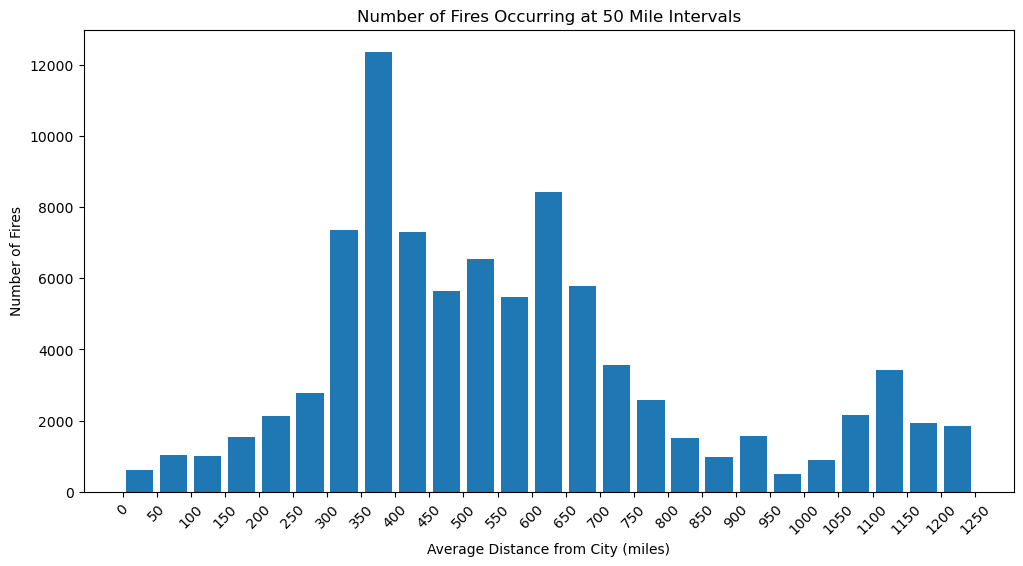

In [51]:
from matplotlib import pyplot as plt

# Define the maximum distance you're interested in
max_distance = df_attributes_estimator['Avg_Distance'].max()

# Determine the number of bins by dividing the max distance by 50
num_bins = int(max_distance // 50) + (max_distance % 50 > 0)

# Create the histogram
plt.figure(figsize=(12, 6))
plt.hist(df_attributes_estimator['Avg_Distance'], bins=num_bins, range=(0, max_distance), rwidth=0.8)

# Set the ticks foramt
plt.xticks(ticks=[i*50 for i in range(num_bins+1)])
plt.xticks(rotation=45)

# Set the labels and title
plt.xlabel('Average Distance from City (miles)')
plt.ylabel('Number of Fires')
plt.title('Number of Fires Occurring at 50 Mile Intervals')

# Show the plot
plt.show()

This histogram shows a graphical representation of the distribution of the number of fires. The x-axis represents the average distance from a city in miles, and the data is grouped into 50-mile intervals. The y-axis represents the number of fires, which is the frequency of the fires within each interval on the x-axis.

This histogram shows a non-uniform distribution of fire occurrences relative to the distance from a city. There are peaks at certain intervals, for example around 350 miles and 600 miles. There are fewer fires at distances closest to 0-200 miles, and the number increases as the distance range increases to around 350 miles, then fluctuates.

The underlying data for this histogram is a set of records of fires, each with a recorded distance from Cedar City. To make this histogram, the data was preprocessed with calculation to sort the distances into 50-mile intervals. The number of fires within each interval was counted and displayed in the histogram.


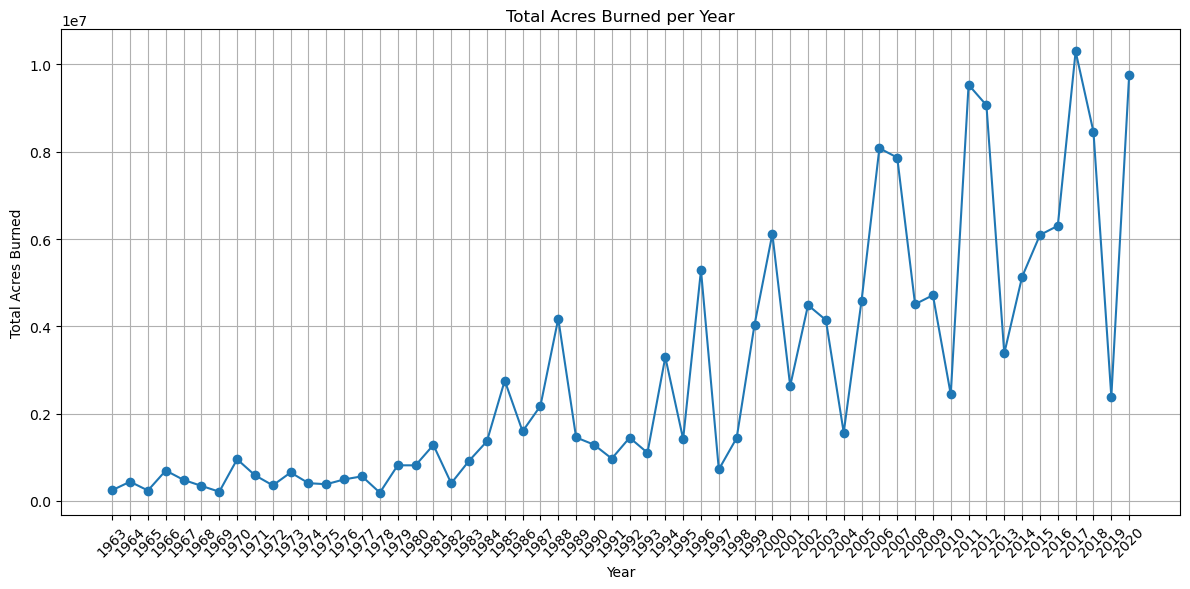

In [52]:
# Filter the DataFrame to include only the fires within the specified distance
df_filtered = df_attributes_estimator[df_attributes_estimator['Avg_Distance'] <= max_distance]

# Group by 'Fire_Year' and sum 'GIS_Acres' to get the total acres burned per year
acres_burned_per_year = df_filtered.groupby('Fire_Year')['GIS_Acres'].sum().reset_index()

# Plotting the time series graph
plt.figure(figsize=(12, 6))
plt.plot(acres_burned_per_year['Fire_Year'], acres_burned_per_year['GIS_Acres'], marker='o')

# Setting the plot title and labels
plt.title('Total Acres Burned per Year')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')

# Optionally, you can add grid lines and specify the tick labels for clarity
plt.grid(True)
plt.xticks(acres_burned_per_year['Fire_Year'], rotation=45)  # Rotate the x-ticks if needed
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Show the plot
plt.show()

This time series graph displays a trend over time of the total acres burned by wildfires each year. There has been an overall increasing pattern over the years, but it has been a big fluctuation, especially since 1988. To read the figure, the viewer can look at the x-axis to identify the year and then see the corresponding point on the y-axis to determine the total acres burned in that year. The x-axis represents the year, ranging from 1963 to 2020. The y-axis represents the total acres burned, and it uses scientific notation to indicate the scale, with the numbers representing multiples of 10 million acres.

The underlying data consists of the year and size of the fires. The data was processed by summing up the total area burned each year to produce the annual points on the graph. Lines are drawn connecting consecutive years' data points to visualize the trend of acres burned over time.


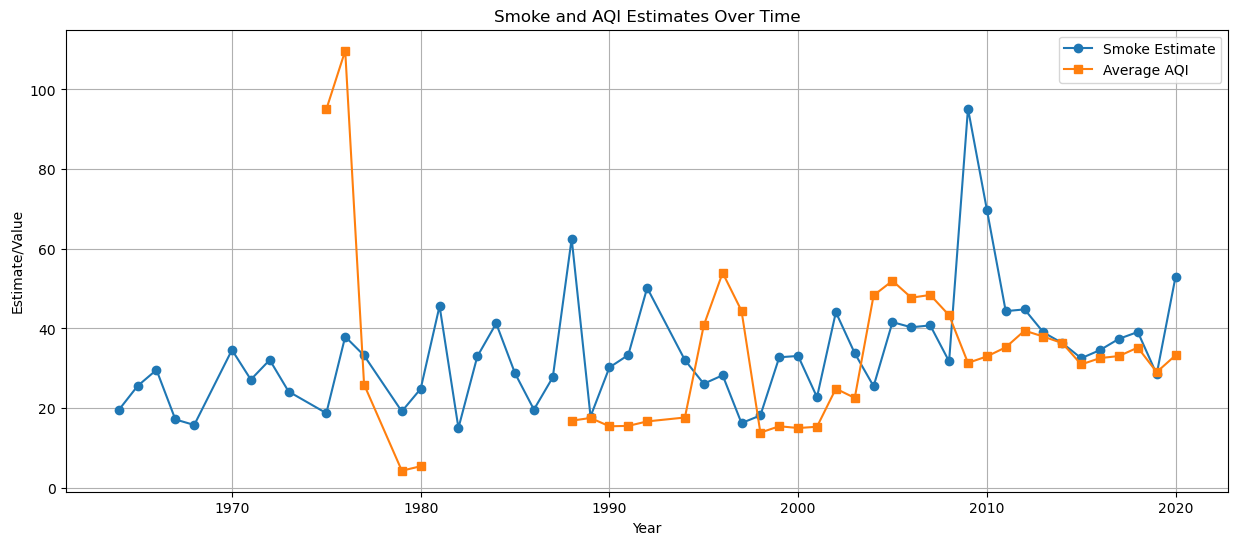

In [109]:
df_aqi = pd.read_csv('df_average_aqi.csv')

df_estimate = df_attributes_estimator[df_attributes_estimator['Scaled_Smoke_Estimate'] > 15]
df_estimate_year = df_estimate.groupby('Fire_Year')['Scaled_Smoke_Estimate'].mean().reset_index()
# Merging the two DataFrames on the year
df_merged = pd.merge(df_estimate_year, df_aqi, how='left', left_on='Fire_Year', right_on='year')


# Plotting the time series graph
plt.figure(figsize=(15, 6))

# Plotting the Smoke Estimate
plt.plot(df_merged['Fire_Year'], df_merged['Scaled_Smoke_Estimate'], label='Smoke Estimate', marker='o')

# Plotting AQI
plt.plot(df_merged['Fire_Year'], df_merged['aqi'], label='Average AQI', marker='s')

# Adding title and labels
plt.title('Smoke and AQI Estimates Over Time')
plt.xlabel('Year')
plt.ylabel('Estimate/Value')

plt.legend()
plt.grid(True)
plt.show()

This time series graph presents 2 sets of data over time, from 1963 to 2020. The blue line represents the smoke estimate generated in the previous section. The orange line represents the average AQI generated from the notebook `epa_air_quality_history.ipynb`. The x-axis represents the year, and the y-axis represents both the smoke estimate index and air quality index since the smoke estimate and AQI have the same range as I rescaled in Section Estimate the Smoke.

The viewer can read the graph by looking at the year on the x-axis and looking at the corresponding estimated values for both smoke and AQI on the y-axis. The lines connecting the data points help to visualize how these estimates and AQI have changed over the years.

The data points for both series do not follow a consistent pattern, indicating variability in smoke and air quality, and the average AQI has missing data for some of the years. The pattern of smoke estimate and average AQI has a relatively consistent pattern in the most recent decade.


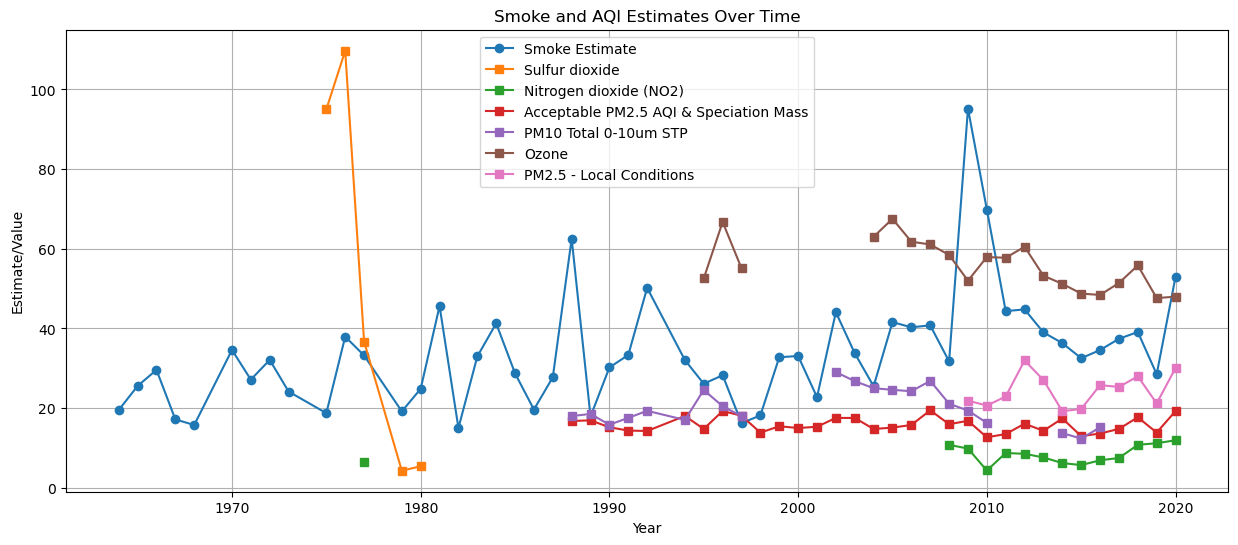

In [108]:
df_param_aqi = pd.read_csv('df_average_param_aqi.csv')

# df_estimate = df_attributes_estimator[df_attributes_estimator['Scaled_Smoke_Estimate'] > 15]
# df_estimate_year = df_estimate.groupby('Fire_Year')['Scaled_Smoke_Estimate'].mean().reset_index()
df_aqi_pivot = df_param_aqi.pivot(index='year', columns='parameter', values='aqi').reset_index()

# Merging the two DataFrames on the year
df_merged = pd.merge(df_estimate_year, df_aqi_pivot, how='left', left_on='Fire_Year', right_on='year')


# Plotting the time series graph
plt.figure(figsize=(15, 6))

# Plotting the Smoke Estimate
plt.plot(df_merged['Fire_Year'], df_merged['Scaled_Smoke_Estimate'], label='Smoke Estimate', marker='o')

# Plotting AQI
for param in df_param_aqi['parameter'].unique():
    plt.plot(df_merged['Fire_Year'], df_merged[param], label=param, marker='s')

# Adding title and labels
plt.title('Smoke and AQI Estimates Over Time')
plt.xlabel('Year')
plt.ylabel('Estimate/Value')

plt.legend()
plt.grid(True)
plt.show()

Similar to the previous time series graph, this time series graph presents 2 sets of data over time, from 1963 to 2020. The blue line represents the smoke estimate generated in the previous section. All other lines represent different pollutant AQIs as shown in the legend in the graph.

The x-axis represents the year, and the y-axis represents both the smoke estimate index and air quality index since the smoke estimate and AQI have the same range as I rescaled in the previous section.

The data points for the smoke estimate and AQIs do not follow a consistent pattern, indicating variability in smoke and air quality, while the pattern of each AQI is consistent. The pattern of smoke estimate and average AQI has a relatively consistent pattern in the most recent decade.


## Predictive Model
In this section, the predictive model is built with the scaled smoke estimate. I used a time series model SARIMAX to train and forecast the next 25 years of smoke estimate.

A SARIMAX model (Seasonal Auturegressive Integrated Moving Average with eXogenous varibales) is used to predict smoke estimates here because of several reasons:
- This model takes seasonality into consideration, which is well-suited for wildfire data with such seasonal patterns.
- The model can handle the non-stationary properties.
- The autoregression and moving average allows the model to account for the relationships between past values (lags) of the series (AR) and past forecast errors (MA).

In [112]:
df_attributes_estimator.head()

,Fire_Year,GIS_Acres,Avg_Distance,Smoke_Estimate,Scaled_Smoke_Estimate
0,1963,40992.458271,492.178296,15598.817855,13.236728
1,1963,25757.090203,515.117415,9486.166192,8.361995
2,1963,45527.210986,495.540991,17415.407189,14.685426
3,1963,10395.010334,407.966436,3391.726242,3.501786
4,1963,9983.605738,477.623831,3197.549787,3.346934


/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36542D+00    |proj g|=  1.27385D-01

At iterate    5    f=  3.31889D+00    |proj g|=  2.17100D-02

At iterate   10    f=  3.27092D+00    |proj g|=  8.48640D-03

At iterate   15    f=  3.26850D+00    |proj g|=  1.91323D-03

At iterate   20    f=  3.26795D+00    |proj g|=  1.49035D-03

At iterate   25    f=  3.26784D+00    |proj g|=  1.44505D-03

At iterate   30    f=  3.26778D+00    |proj g|=  1.15271D-04

At iterate   35    f=  3.26777D+00    |proj g|=  4.01643D-05

At iterate   40    f=  3.26777D+00    |proj g|=  8.56070D-05

At iterate   45    f=  3.26777D+00    |proj g|=  8.83205D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

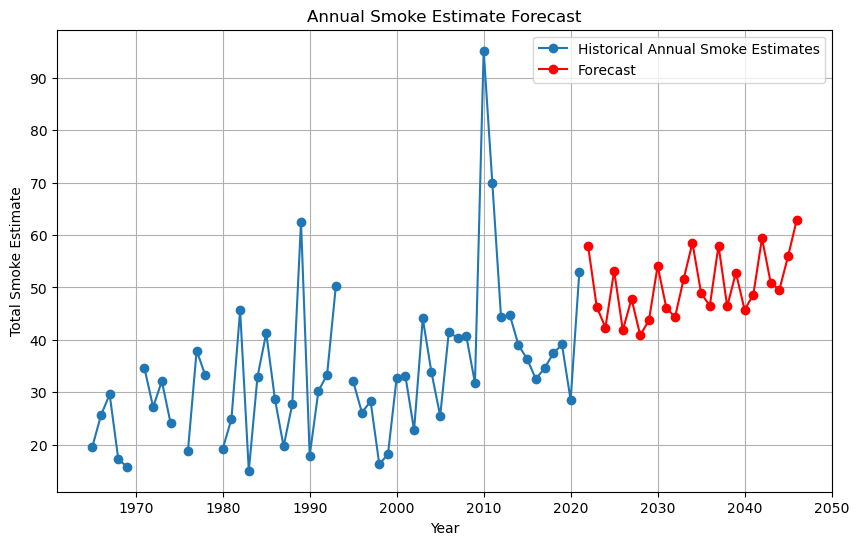

In [147]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

data = df_attributes_estimator.copy()

# Convert 'Year' to a datetime object and make it the index
data['Year'] = pd.to_datetime(data['Fire_Year'], format='%Y')
data.set_index('Year', inplace=True)
data = data[data['Scaled_Smoke_Estimate'] > 15]

# Aggregate smoke estimates by year
annual_smoke = data['Scaled_Smoke_Estimate'].resample('A').mean()

# Fit the SARIMAX model
# The order and seasonal_order need to be determined based on your specific data
model = SARIMAX(annual_smoke, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fitted_model = model.fit()

# Forecast the next 25 years
forecast = fitted_model.get_forecast(steps=25)
forecast_index = pd.date_range(annual_smoke.index[-1] + pd.offsets.YearEnd(), periods=25, freq='A')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plot the forecast alongside historical data
plt.figure(figsize=(10, 6))
plt.plot(annual_smoke, label='Historical Annual Smoke Estimates', marker='o')
plt.plot(forecast_series, label='Forecast', color='red', marker='o')
plt.title('Annual Smoke Estimate Forecast')
plt.xlabel('Year')
plt.ylabel('Total Smoke Estimate')
plt.legend()
plt.grid(True)
plt.show()


In [137]:
# Print the forecast values
print(forecast_series)

2021-12-31    1.233675
2022-12-31    1.096594
2023-12-31    1.294346
2024-12-31    1.490849
2025-12-31    1.207075
2026-12-31    1.327541
2027-12-31    1.301701
2028-12-31    1.225679
2029-12-31    1.382875
2030-12-31    1.470533
2031-12-31    1.386384
2032-12-31    1.503202
2033-12-31    1.399928
2034-12-31    1.257809
2035-12-31    1.460441
2036-12-31    1.662124
2037-12-31    1.370430
2038-12-31    1.493153
2039-12-31    1.470148
2040-12-31    1.394964
2041-12-31    1.556897
2042-12-31    1.638102
2043-12-31    1.537770
2044-12-31    1.669508
2045-12-31    1.565947
Freq: A-DEC, Name: predicted_mean, dtype: float64


As the graph above shows, the red part represents the prediction with the model, while the blue line represents the smoke estimates. The prediction shows an increasing fluctuation for the future 25 years.